Bidirectional

In [ ]:
import tensorflow as tf
gpus =tf.config.experimental.list_physical_devices('GPU')
gpu = gpus[0]

tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
!pip install hazm
#!pip install tensorflow-gpu

     |████████████████████████████████| 316 kB 10.8 MB/s 
     |████████████████████████████████| 233 kB 59.7 MB/s 
     |████████████████████████████████| 1.4 MB 55.9 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394489 sha256=c9bdf68062609fb6ba747b3a2f9906a36bfcf54ed5b004708e7fcdbc58afe882
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=155184 sha256=75a12709adca8b184a19324d26c38dccae71b33ec3076de6d0a8e875e026040c
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from hazm import *
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/persian_news

/content/drive/MyDrive/persian_news


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/persian_news/persian_news/train.csv', sep='\t', encoding="utf-8")
data

,content,true_label_id,prediction label
0,حسن جوهرچی بازیگر سینما و تلویزیون ایران در گف...,5,فرهنگی هنری
1,به گزارش گروه بین الملل باشگاه خبرنگاران جوان ...,2,فرهنگی هنری
2,به گزارش خبرنگار فوتبال و فوتسال گروه ورزشی با...,6,فرهنگی هنری
3,به‌ گزارش گروه اقتصادی باشگاه خبرنگاران به نقل...,1,فرهنگی هنری
4,به گزارش خبرنگار حوزه قرآن و عترت گروه فرهنگی ...,5,فرهنگی هنری
...,...,...,...
1639,طرح رجیستری که برای قانون‌مند شدن واردات موبای...,4,علمی فناوری
1640,به گزارش گروه بین‌الملل باشگاه خبرنگاران جوان ...,2,فرهنگی هنری
1641,به گزارش گروه ورزشی باشگاه خبرنگاران، مرحله یک...,6,فرهنگی هنری
1642,مجله شبانه باشگاه خبرنگاران؛ عطا کردی خطا کردم...,0,فرهنگی هنری


In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/persian_news/persian_news/test.csv', sep='\t', encoding="utf-8")
testdata

,Unnamed: 0,content,label,label_id
0,0,حسن جوهرچی بازیگر سینما و تلویزیون ایران در گف...,فرهنگی هنری,5
1,1,به گزارش گروه بین الملل باشگاه خبرنگاران جوان ...,بین الملل,2
2,2,به گزارش خبرنگار فوتبال و فوتسال گروه ورزشی با...,ورزشی,6
3,3,به‌ گزارش گروه اقتصادی باشگاه خبرنگاران به نقل...,اقتصادی,1
4,4,به گزارش خبرنگار حوزه قرآن و عترت گروه فرهنگی ...,فرهنگی هنری,5
...,...,...,...,...
1639,1639,طرح رجیستری که برای قانون‌مند شدن واردات موبای...,علمی فناوری,4
1640,1640,به گزارش گروه بین‌الملل باشگاه خبرنگاران جوان ...,بین الملل,2
1641,1641,به گزارش گروه ورزشی باشگاه خبرنگاران، مرحله یک...,ورزشی,6
1642,1642,مجله شبانه باشگاه خبرنگاران؛ عطا کردی خطا کردم...,اجتماعی,0


In [ ]:
sentence_train = data['content']
label_train = data['true_label_id']

print('Number of training sentence: ', sentence_train.shape)
print('Number of training label: ', label_train.shape)

Number of training sentence:  (1644,)
Number of training label:  (1644,)


In [ ]:
data.shape, testdata.shape

((1644, 3), (1644, 4))

In [ ]:
data.true_label_id.value_counts()

5    256
4    244
3    227
0    217
7    209
2    197
1    156
6    138
Name: true_label_id, dtype: int64

In [ ]:
data.isnull().sum()

content             0
true_label_id       0
prediction label    0
dtype: int64

In [ ]:
testdata.isnull().sum()

Unnamed: 0    0
content       0
label         0
label_id      0
dtype: int64

In [ ]:
from collections import Counter
cnt = Counter(label_train)
cnt = dict(cnt)
print(cnt)

{5: 256, 2: 197, 6: 138, 1: 156, 7: 209, 3: 227, 4: 244, 0: 217}


In [ ]:
sentence_train = np.asarray(sentence_train)
label_train = np.asarray(label_train)

categorical_label_train = to_categorical(label_train, 8)
categorical_label_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import re
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()

def clean_data(doc):
    doc = normalizer.normalize(doc) 
    tokenized = word_tokenize(doc)  
    tokens = []
    for token in tokenized:      
      token = re.sub("[،:.,;()/+]", " ", token) 
      token = re.sub(r"\!+","!", token)
      token = re.sub(r"\؟+","؟", token)
      token = re.sub(r"\u200c", " ", token)
      token = token.lower()
      token = re.sub('<[^>]*>', '', token)
      token = re.sub('\S*@\S*\s?', '', token)
      token = re.sub('https?://[A-Za-z0-9]','',token)
      token = re.sub('[^a-zA-Z]',' ',token)
      token = re.sub(r"\'s", "", token)
      token = re.sub(r"\'ve", "", token)
      token = re.sub(r"n\'t", "", token)
      token = re.sub(r"\'re", "", token)
      token = re.sub(r"\'d", "", token)
      token = re.sub(r"\'11", "", token)
      token = re.sub(r"'", "", token)
      token = re.sub(r"\s{2,}", "", token)
      tokens.append(token)

    tokens = [w for w in tokens if not len(w) <= 1]  
    tokens = [w for w in tokens if not w.isdigit()] 
    tokens = [lemmatizer.lemmatize(w) for w in tokens] 
    tokens = [stemmer.stem(w) for w in tokens] 
    tokens = ' '.join(tokens)
    return tokens

In [ ]:
train_docs = np.empty_like(sentence_train)
for index, document in enumerate(sentence_train):
  train_docs[index] = clean_data(document)

In [ ]:
num_words = 1644
# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)
print(encoded_docs)

[[], [], [], [], [], [], [], [], [], [288, 289, 290, 291, 292, 13, 13, 293, 149, 150, 13, 294, 149, 150, 13, 13, 151, 59, 295, 151, 59, 90, 296, 152, 297, 7, 153, 153], [], [], [], [], [], [154, 155, 156, 48, 91, 156, 91, 298, 154, 155, 91], [], [], [], [], [], [], [], [], [], [299, 60, 157], [], [], [92, 92, 92], [], [9, 9, 61, 300, 49, 9, 9, 61, 9, 61], [], [], [], [], [158], [], [], [], [], [], [], [], [], [], [], [301], [302, 303, 304, 50], [], [], [], [305, 306], [], [], [], [], [], [], [], [], [], [], [159], [], [], [], [31, 9, 9, 23, 14, 14, 9, 9, 23, 31, 31, 31, 160, 31], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [93], [], [], [], [], [], [], [4], [], [], [38, 51, 62, 307, 308, 309, 310, 311, 312], [313], [], [], [], [], [], [], [], [], [], [], [], [63, 63, 63], [314], [], [], [], [], [], [], [], [32], [], [161, 315, 316], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [317, 318], [], [], [], [], [], [], [], [], [], [], [], [], [], [31

In [ ]:
max_length = max([len(s.split()) for s in train_docs])
max_length

60

In [ ]:
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
x_train_padded[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
vocab_size = len(tokenizer.word_index)
embed_size = 300

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPool1D()) 
model.add(Dense(1024))
model.add(Dropout(0.25)) 
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax')) 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy"])
model.summary()
batch_size = 64
epochs = 20

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 300)           287700    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 256)           439296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 128)           164352    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

In [ ]:
history = model.fit(x_train_padded, categorical_label_train,
                             batch_size=batch_size, epochs=epochs,
                             shuffle=True)

Epoch 1/20
108/108 [==============================] - 38s 306ms/step - loss: 0.3655 - categorical_accuracy: 0.8677
Epoch 2/20
108/108 [==============================] - 33s 305ms/step - loss: 0.3519 - categorical_accuracy: 0.8702
Epoch 3/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3389 - categorical_accuracy: 0.8750
Epoch 4/20
108/108 [==============================] - 33s 306ms/step - loss: 0.3465 - categorical_accuracy: 0.8767
Epoch 5/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3271 - categorical_accuracy: 0.8754
Epoch 6/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3300 - categorical_accuracy: 0.8743
Epoch 7/20
108/108 [==============================] - 33s 306ms/step - loss: 0.3313 - categorical_accuracy: 0.8753
Epoch 8/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3540 - categorical_accuracy: 0.8733
Epoch 9/20
108/108 [==============================] - 33s 307ms/step - loss: 0.3

In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/persian_news/persian_news/test.csv', sep='\t', encoding="utf-8")

x_test = testdata['content']
y_test = testdata['label_id']

In [ ]:
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (852,)
Number of testing label:  (852,)


In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_data(document)

encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

categorical_y_test = to_categorical(y_test, 7)

loss, acc = model.evaluate(x_test_padded, categorical_y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

27/27 [==============================] - 4s 99ms/step - loss: 1.3802 - categorical_accuracy: 0.7465
Test Accuracy: 74.647886


LSTM

In [ ]:
vocab_size = len(tokenizer.word_index)

model_blstm = Sequential()

model_blstm.add(Embedding(vocab_size, 300, input_length=max_length))

model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.25))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(8, activation='softmax'))

model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy"])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 12

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 300)           287700    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 2408      
Total params: 380,408
Trainable params: 380,408
Non-trainable params: 0
________________________________________________

In [ ]:
hist_blstm = model_blstm.fit(x_train_padded, categorical_label_train,
                             batch_size=batch_size_blstm, epochs=epochs_blstm,
                             shuffle=True)

Epoch 1/12
108/108 [==============================] - 9s 82ms/step - loss: 1.3095 - categorical_accuracy: 0.5068
Epoch 2/12
108/108 [==============================] - 9s 82ms/step - loss: 0.7621 - categorical_accuracy: 0.7542
Epoch 3/12
108/108 [==============================] - 9s 81ms/step - loss: 0.5468 - categorical_accuracy: 0.8247
Epoch 4/12
108/108 [==============================] - 9s 80ms/step - loss: 0.4501 - categorical_accuracy: 0.8447
Epoch 5/12
108/108 [==============================] - 9s 80ms/step - loss: 0.3942 - categorical_accuracy: 0.8573
Epoch 6/12
108/108 [==============================] - 9s 80ms/step - loss: 0.3649 - categorical_accuracy: 0.8677
Epoch 7/12
108/108 [==============================] - 9s 81ms/step - loss: 0.3434 - categorical_accuracy: 0.8753
Epoch 8/12
108/108 [==============================] - 9s 81ms/step - loss: 0.3258 - categorical_accuracy: 0.8821
Epoch 9/12
108/108 [==============================] - 9s 83ms/step - loss: 0.3199 - categorical_

In [ ]:
accr = model.evaluate(x_train_padded)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

216/216 [==============================] - 60s 278ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test set
  Loss: 0.000
  Accuracy: 0.000


In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/persian_news/persian_news/test.csv', sep='\t', encoding="utf-8")

x_test = testdata['content']
y_test = testdata['true_label_id']

print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (852,)
Number of testing label:  (852,)


In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_data(document)

encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

categorical_y_test = to_categorical(y_test, 7)

loss, acc = model.evaluate(x_test_padded, categorical_y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

27/27 [==============================] - 4s 99ms/step - loss: 1.3802 - categorical_accuracy: 0.7465
Test Accuracy: 74.647886


GRU

In [ ]:
vocab_size = len(tokenizer.word_index)
embed_size = 300

In [ ]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

mode = Sequential()
mode.add(Embedding(vocab_size, embed_size, input_length=max_length))
mode.add(GRU(50, return_sequences=True))
mode.add(Dropout(0.2))
mode.add(GRU(100,return_sequences=False))
mode.add(Dropout(0.2))
mode.add(Dense(1, activation = "linear"))

mode.compile(loss="mean_squared_error",optimizer="rmsprop",metrics=['accuracy'])

history = mode.fit(x_train_padded,categorical_label_train,epochs= 12,batch_size=64,validation_split=0.2)

Epoch 1/12
87/87 [==============================] - 18s 163ms/step - loss: 0.1259 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 2/12
87/87 [==============================] - 13s 152ms/step - loss: 0.1227 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 3/12
87/87 [==============================] - 13s 153ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 4/12
87/87 [==============================] - 13s 153ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 5/12
87/87 [==============================] - 13s 150ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 6/12
87/87 [==============================] - 13s 149ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 7/12
87/87 [==============================] - 13s 149ms/step - loss: 0.1225 - accuracy: 0.8571 - val_loss: 0.1224 - val_accuracy: 0.8571

In [ ]:
train_loss, train_accuracy = mode.evaluate(x_train_padded, categorical_label_train, batch_size=64)
train_accuracy

108/108 [==============================] - 7s 62ms/step - loss: 0.1225 - accuracy: 0.8571


0.8571420907974243

In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/persian_news/persian_news/test.csv', sep='\t', encoding="utf-8")

sentence_test = data['content']
label_test = data['label_id']

print('Number of testing sentence: ', sentence_test.shape)
print('Number of testing label: ', label_test.shape)

Number of testing sentence:  (6896,)
Number of testing label:  (6896,)


In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_data(document)

encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

categorical_y_test = to_categorical(y_test, 7)

loss, acc = mode.evaluate(x_test_padded, categorical_y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

27/27 [==============================] - 1s 49ms/step - loss: 0.1225 - accuracy: 0.8571
Test Accuracy: 85.714293


In [ ]:
y_pred = model.predict_classes(x_test_padded)

In [ ]:
content = []
true_label_id = []
pred_label_id = []
اجتماعی = 0
اقتصادی  = 0
بین_الملل = 0
سیاسی = 0
علمی_فناوری  = 0
فرهنگی_هنری = 0
ورزشی = 0
پزشکی = 0
for i in range(len(y_pred)):
  content.append(x_test[i])
  true_label_id.append(y_test[i])

  if y_pred[i] == 0:
    اجتماعی +=1
    pred_label_id.append("اجتماعی")
  elif y_pred[i] == 1:
    اقتصادی +=1
    pred_label_id.append("اقتصادی")
  elif y_pred[i] == 2:
    بین_الملل +=1
    pred_label_id.append("بین الملل")
  if y_pred[i] == 3:
    سیاسی +=1
    pred_label_id.append("سیاسی")
  elif y_pred[i] == 4:
    علمی_فناوری +=1
    pred_label_id.append("علمی فناوری")
  elif y_pred[i] == 5:
    فرهنگی_هنری +=1
    pred_label_id.append("فرهنگی هنری")
  elif y_pred[i] == 6:
    ورزشی +=1
    pred_label_id.append("ورزشی")
  elif y_pred[i] == 7:
    پزشکی +=1
    pred_label_id.append("پزشکی")

print("اجتماعی: " , (اجتماعی/27)*100)
print("اقتصادی: " , (اقتصادی/27)*100)
print("بین_الملل: " , (بین_الملل/27)*100)
print("سیاسی: " , (سیاسی/27)*100)
print("علمی_فناوری: " , (علمی_فناوری/27)*100)
print("فرهنگی_هنری: " , (فرهنگی_هنری/27)*100)
print("ورزشی: " , (ورزشی/27)*100)
print("پزشکی: " , (پزشکی/27)*100)

اجتماعی:  11.11111111111111
اقتصادی:  51.85185185185185
بین_الملل:  0.0
سیاسی:  0.0
علمی_فناوری:  555.5555555555555
فرهنگی_هنری:  5325.925925925926
ورزشی:  11.11111111111111
پزشکی:  133.33333333333331


<Figure size 432x288 with 0 Axes>

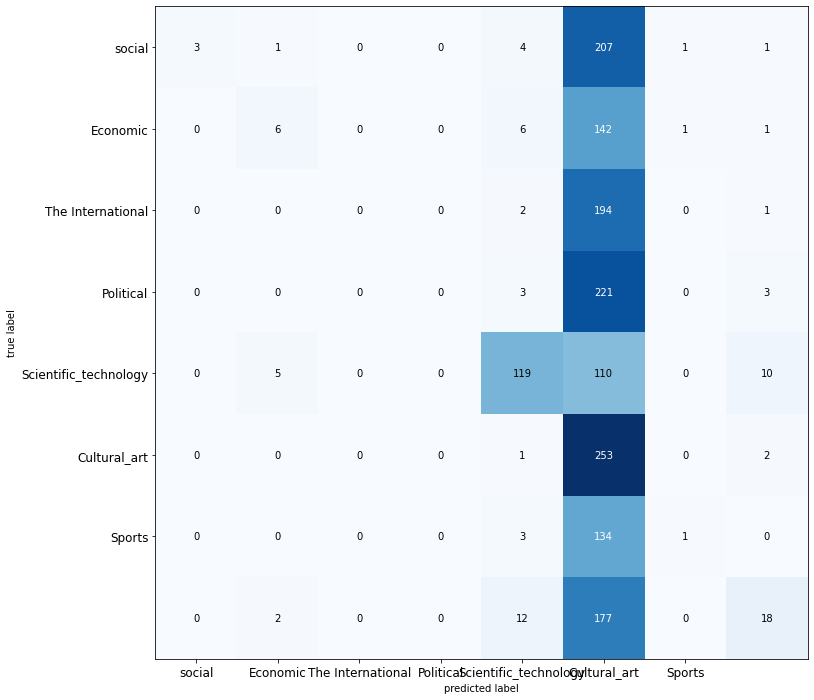

In [ ]:
dataFrame = pd.DataFrame({"content":content, "true_label_id":true_label_id, "prediction label":pred_label_id})
dataFrame.to_csv('/content/drive/MyDrive/persian_news/persian_news/train.csv', sep='\t', index=False)

label = ['social', 'Economic', 'The International', 'Political', 'Scientific_technology', 'Cultural_art', 'Sports', 'medical']
y_pred = [np.argmax(i) for i in model.predict(x_test_padded)]
cm  = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(7), label, fontsize=12)
plt.yticks(range(7), label, fontsize=12)
plt.show()

In [ ]:
def modelDemo(news_content):

  #News Label
  label = [' اجتماعی', 'اقتصادی', ' بین_الملل ', 'سیاسی', 'علمی_فناوری ', ' فرهنگی_هنری', 'ورزشی', 'پزشکی']
  test_seq = pad_sequences(tokenizer.texts_to_sequences(news_content), maxlen=max_length)
  y_pred = [label[np.argmax(i)] for i in mode.predict(test_seq)]

  for news, label in zip(news_content, y_pred):
      print('{} - {}'.format(colored(news, 'green'), colored(label, 'red')))

from termcolor import colored

modelDemo(['این تحقیقات پس از انجام جراحی و خارج کردن تومور ملانوم از بدن موش‌ها، محققان محل زخم جراحی را با استفاده از افشانه کلسیم کربنات آغشته کردندم.'])

این تحقیقات پس از انجام جراحی و خارج کردن تومور ملانوم از بدن موش‌ها، محققان محل زخم جراحی را با استفاده از افشانه کلسیم کربنات آغشته کردندم. -  فرهنگی_هنری
